In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import timedelta
from pandas.plotting import scatter_matrix

import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from bayes_opt import BayesianOptimization

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

import pickle

# About data

- Data source: CRSP
- Sample period: 2000-01 - 2018-12
* File name: crsp_m_2000.csv, sp2000.csv

* crsp_m_2000.csv
    - date: date
    - permno: unique id of each stock
    - prc: close price (< 0 if it's the mean of bid and ask prices)
    - ret: monthly return
    - shrout: shares outstanding (in 1000 shares)
    - trading volume (in 100 shares)
                        
                        
* sp2000.csv
    - caldt: date
    - vwretd: value-wight return
    - ewretd: equal-wight return
    - sprtrn: monthly return <= Benchmark

In [187]:
crsp = pd.read_csv('crsp_m_2000.csv')
sp500 = pd.read_csv('sp2000.csv') # Benchmark

# EDA

In [188]:
crsp.head()

,date,permno,prc,ret,shrout,vol
0,2000-01-31,80000,16.750,-0.007407,3532.0,1547.0
1,2000-02-29,80000,16.375,-0.022388,3551.0,2394.0
2,2000-03-31,80000,14.750,-0.099237,3558.0,2430.0
3,2000-04-28,80000,14.250,-0.033898,3558.0,2122.0
4,2000-05-31,80000,15.375,0.078947,3577.0,1841.0


In [189]:
sp500.head()

,caldt,vwretd,ewretd,sprtrn
0,20000131,-0.049630,-0.057249,-0.050904
1,20000229,-0.017458,-0.045099,-0.020108
2,20000331,0.098488,0.109941,0.096720
3,20000428,-0.031583,0.008074,-0.030796
4,20000531,-0.022304,0.016657,-0.021915


In [190]:
crsp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609247 entries, 0 to 609246
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    609247 non-null  object 
 1   permno  609247 non-null  int64  
 2   prc     593733 non-null  float64
 3   ret     595044 non-null  float64
 4   shrout  609247 non-null  float64
 5   vol     598363 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 27.9+ MB


In [191]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   caldt   228 non-null    int64  
 1   vwretd  228 non-null    float64
 2   ewretd  228 non-null    float64
 3   sprtrn  228 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 7.2 KB


In [192]:
crsp.describe().T

,count,mean,std,min,25%,50%,75%,max
permno,609247.0,87076.846204,3584.821611,80000.0,84229.000000,87236.00,90081.000000,9.343600e+04
prc,593733.0,19.242766,55.803079,-1457.5,3.450000,10.48,23.809999,4.736000e+03
ret,595044.0,0.006790,0.208501,-1.0,-0.077211,0.00,0.073465,1.577419e+01
shrout,609247.0,67779.193119,176132.801242,2.0,11777.000000,27057.00,57690.500000,6.433649e+06
vol,598363.0,132897.348414,458537.363789,0.0,4859.000000,27031.00,98965.000000,3.875707e+07


In [193]:
sp500.describe().T

,count,mean,std,min,25%,50%,75%,max
caldt,228.0,2.009068e+07,54893.858410,2.000013e+07,2.004100e+07,2.009068e+07,2.014036e+07,2.018123e+07
vwretd,228.0,4.945917e-03,0.041833,-1.669800e-01,-1.656375e-02,9.867500e-03,3.096000e-02,1.090140e-01
ewretd,228.0,8.264452e-03,0.048712,-2.075620e-01,-1.660050e-02,1.099950e-02,3.615150e-02,1.848570e-01
sprtrn,228.0,3.235355e-03,0.041924,-1.694250e-01,-1.792650e-02,8.439500e-03,2.849975e-02,1.077230e-01


In [194]:
crsp['relvol'] = 0.1 * crsp.vol / crsp.shrout
crsp['date'] = pd.to_datetime(crsp.date)
crsp['prc'] = abs(crsp.prc)

sp500['caldt'] = pd.to_datetime([str(x) for x in sp500.caldt])

In [195]:
x_cols = ['prc', 'ret', 'shrout', 'relvol', 'vol']

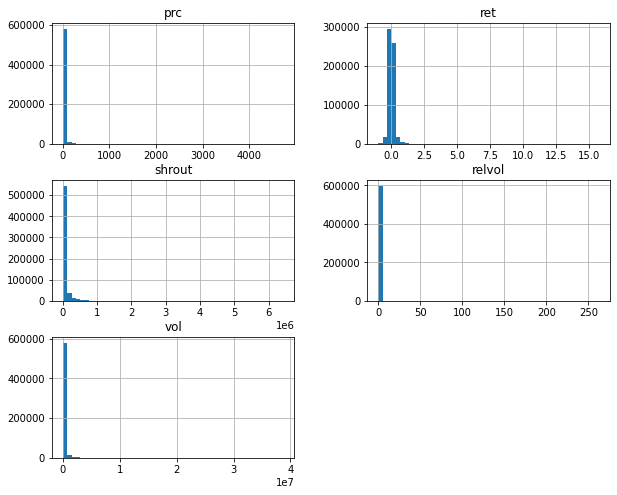

In [196]:
crsp[x_cols].hist(bins=50, figsize=(10, 8))
plt.show()

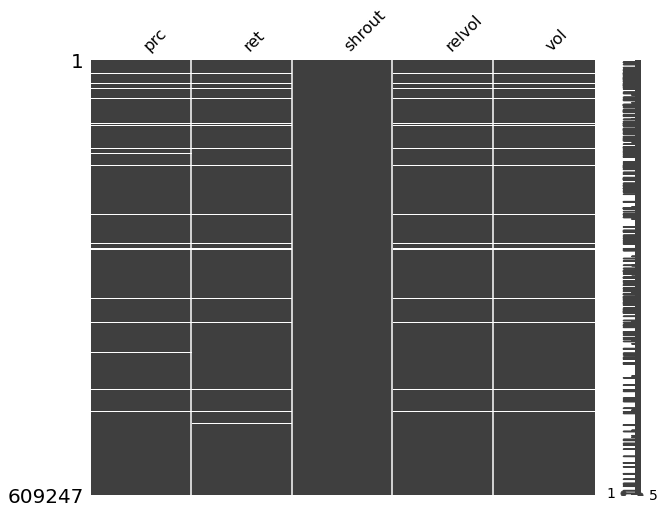

In [197]:
msno.matrix(crsp[x_cols], figsize=(10, 8))
plt.show()

In [198]:
(crsp.describe().T['max'] - crsp.describe().T['mean']) / crsp.describe().T['std']

permno      1.773911
prc        84.965003
ret        75.622786
shrout     36.142443
vol        84.233423
relvol    350.754796
dtype: float64

In [199]:
len(crsp)

609247

In [200]:
crsp.dropna(inplace=True)
len(crsp)

590656

In [201]:
lb = crsp.quantile(q=0.01)
ub = crsp.quantile(q=0.99)

crsp = crsp[crsp.ret >= lb.ret]
crsp = crsp[crsp.ret <= ub.ret]
len(crsp)

578864

- clip 방식으로 상위/하위 1% 데이터 제거
- ret의 표준편차가 크게 줄어든 것을 확인

In [202]:
(crsp.describe().T['max'] - crsp.describe().T['mean']) / crsp.describe().T['std']

permno      1.765079
prc        84.041292
ret         4.378000
shrout     35.730441
vol        87.801982
relvol    338.477353
dtype: float64

In [203]:
crsp.sort_values(['permno', 'date'], inplace=True)
crsp['label'] = pd.concat(pd.qcut(-q, 10, labels=False) for f, q in crsp.groupby('date')['ret'])
crsp['tgt_ret'] = crsp.groupby('permno')['ret'].shift(-1)
crsp['tgt_label'] = crsp.groupby('permno')['label'].shift(-1)
crsp.dropna(inplace=True)
len(crsp)
crsp.head()

,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label
0,2000-01-31,80000,16.750,-0.007407,3532.0,1547.0,0.043800,4,-0.022388,6.0
1,2000-02-29,80000,16.375,-0.022388,3551.0,2394.0,0.067418,6,-0.099237,6.0
2,2000-03-31,80000,14.750,-0.099237,3558.0,2430.0,0.068297,6,-0.033898,3.0
3,2000-04-28,80000,14.250,-0.033898,3558.0,2122.0,0.059640,3,0.078947,1.0
4,2000-05-31,80000,15.375,0.078947,3577.0,1841.0,0.051468,1,0.097561,3.0


In [204]:
x_cols = ['prc', 'ret', 'shrout', 'vol', 'relvol', 'label', 'tgt_ret', 'tgt_label']

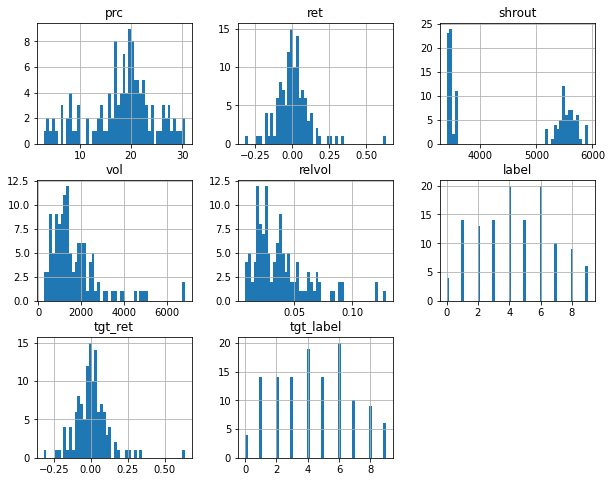

In [205]:
crsp[crsp.permno == 80000][x_cols].hist(bins=50, figsize=(10, 8))
plt.show()

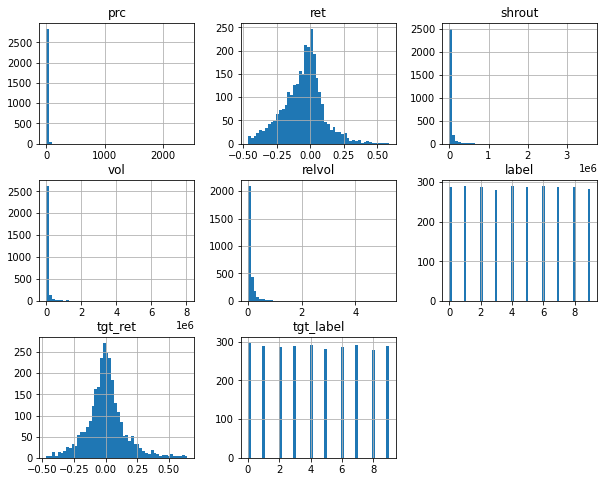

In [206]:
crsp[crsp.date == '2002-12-31'][x_cols].hist(bins=50, figsize=(10, 8))
plt.show()

# Factor

- size : log(시가총액)
- mom3m : 3개월 모멘텀
- mom6m : 6개월 모멘텀
- mom9m : 9개월 모멘텀
- mom12m : 12개월 모멘텀
- relvol : 주식 발행량 대비 거래량

In [207]:
# size factor
crsp['size'] = np.log(crsp.prc * crsp.shrout)

crsp['cumret'] = crsp.groupby('permno')['ret'].apply(lambda x: (x+1).cumprod())
crsp['row_cnt'] = crsp.groupby('permno').cumcount()

# mom3m, mom6m, mom9m, mom12m factor
numer = crsp.shift(1)

denom = crsp.shift(3)
crsp['mom3m'] = numer.cumret / denom.cumret - 1
crsp.loc[crsp.row_cnt < 3, 'mom3m'] = np.nan
crsp['prd3m'] = 12 * (numer.date.dt.year - denom.date.dt.year) + (numer.date.dt.month - denom.date.dt.month) + 1

denom = crsp.shift(6)
crsp['mom6m'] = numer.cumret / denom.cumret - 1
crsp.loc[crsp.row_cnt < 6, 'mom6m'] = np.nan
crsp['prd6m'] = 12 * (numer.date.dt.year - denom.date.dt.year) + (numer.date.dt.month - denom.date.dt.month) + 1

denom = crsp.shift(9)
crsp['mom9m'] = numer.cumret / denom.cumret - 1
crsp.loc[crsp.row_cnt < 9, 'mom9m'] = np.nan
crsp['prd9m'] = 12 * (numer.date.dt.year - denom.date.dt.year) + (numer.date.dt.month - denom.date.dt.month) + 1

denom = crsp.shift(12)
crsp['mom12m'] = numer.cumret / denom.cumret - 1
crsp.loc[crsp.row_cnt < 12, 'mom12m'] = np.nan
crsp['prd12m'] = 12 * (numer.date.dt.year - denom.date.dt.year) + (numer.date.dt.month - denom.date.dt.month) + 1

In [208]:
crsp.dropna(inplace=True)

In [209]:
crsp = crsp[crsp.prd3m == 3]
crsp = crsp[crsp.prd6m == 6]
crsp = crsp[crsp.prd9m == 9]
crsp = crsp[crsp.prd12m == 12]

crsp.drop(columns=['prd3m', 'prd6m', 'prd9m', 'prd12m'], inplace=True)
crsp.sort_values(['permno', 'date'], inplace=True)
crsp

,date,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,row_cnt,mom3m,mom6m,mom9m,mom12m
12,2001-01-31,80000,20.125000,0.025478,3564.0,1869.0,0.052441,6,-0.003106,3.0,11.180602,1.192593,12,0.019481,0.226563,0.377193,0.171642
13,2001-02-28,80000,20.062500,-0.003106,3473.0,811.0,0.023352,3,0.099688,1.0,11.151626,1.188889,13,0.080537,0.183824,0.308943,0.229008
14,2001-03-30,80000,22.062500,0.099688,3466.0,2518.0,0.072649,1,-0.027989,6.0,11.244636,1.307407,14,0.022293,0.163043,0.188889,0.360169
15,2001-04-30,80000,21.445000,-0.027989,3466.0,1936.0,0.055857,6,0.010026,5.0,11.216248,1.270815,15,0.096273,0.146104,0.378906,0.548246
16,2001-05-31,80000,21.660000,0.010026,3483.0,905.0,0.025983,5,-0.021237,5.0,11.231117,1.283556,16,0.068910,0.151409,0.261471,0.394797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609241,2018-07-31,93436,298.140015,-0.130660,170593.0,1723953.0,1.010565,9,0.011806,5.0,17.744599,6.909528,95,0.166894,-0.032062,0.034446,0.060222
609242,2018-08-31,93436,301.660004,0.011806,170593.0,2773316.0,1.625692,5,-0.122290,8.0,17.756336,6.991105,96,0.047097,-0.130939,-0.034677,-0.162293
609243,2018-09-28,93436,264.769989,-0.122290,171578.0,1960767.0,1.142785,8,0.274011,0.0,17.631655,6.136163,97,-0.120397,0.133506,-0.031123,-0.115626
609244,2018-10-31,93436,337.320007,0.274011,171733.0,2864231.0,1.667840,0,0.039013,3.0,17.874728,7.817542,98,-0.111927,-0.099115,-0.252717,-0.201369


In [210]:
crsp.corr().tgt_label.sort_values(ascending=False)

tgt_label    1.000000
permno       0.019478
relvol       0.015916
ret          0.012109
vol          0.001577
row_cnt     -0.004896
shrout      -0.005502
label       -0.009328
cumret      -0.019819
prc         -0.021403
mom3m       -0.023480
mom6m       -0.033518
mom9m       -0.039148
mom12m      -0.044188
size        -0.048831
tgt_ret     -0.826067
Name: tgt_label, dtype: float64

In [211]:
crsp.corr().style.background_gradient(cmap='summer_r')

,permno,prc,ret,shrout,vol,relvol,label,tgt_ret,tgt_label,size,cumret,row_cnt,mom3m,mom6m,mom9m,mom12m
permno,1.000000,-0.014144,-0.016623,0.022337,0.005002,0.030845,0.018638,-0.014803,0.019478,0.053823,-0.053806,-0.169627,-0.021792,-0.027276,-0.029984,-0.029554
prc,-0.014144,1.000000,0.032020,0.055281,0.043736,0.055083,-0.047611,0.004117,-0.021403,0.332683,0.198629,0.116880,0.044780,0.067114,0.079022,0.088495
ret,-0.016623,0.032020,1.000000,-0.001315,0.000548,0.027517,-0.825818,0.012303,0.012109,0.076412,0.036931,0.002624,0.014219,0.029198,0.026550,0.028997
shrout,0.022337,0.055281,-0.001315,1.000000,0.657809,0.054691,-0.005791,-0.001750,-0.005502,0.470755,0.083047,0.116319,0.000017,0.002109,0.003662,0.005540
vol,0.005002,0.043736,0.000548,0.657809,1.000000,0.326753,-0.003327,-0.007684,0.001577,0.374461,0.052810,0.092563,-0.001148,0.004935,0.011060,0.018058
relvol,0.030845,0.055083,0.027517,0.054691,0.326753,1.000000,-0.016224,-0.020155,0.015916,0.232559,0.051311,0.052810,0.022545,0.042977,0.058867,0.074704
label,0.018638,-0.047611,-0.825818,-0.005791,-0.003327,-0.016224,1.000000,0.010366,-0.009328,-0.101537,-0.051835,-0.005835,0.001469,-0.017848,-0.026797,-0.033009
tgt_ret,-0.014803,0.004117,0.012303,-0.001750,-0.007684,-0.020155,0.010366,1.000000,-0.826067,0.013780,0.003351,0.001341,0.032066,0.028684,0.030986,0.035437
tgt_label,0.019478,-0.021403,0.012109,-0.005502,0.001577,0.015916,-0.009328,-0.826067,1.000000,-0.048831,-0.019819,-0.004896,-0.023480,-0.033518,-0.039148,-0.044188
size,0.053823,0.332683,0.076412,0.470755,0.374461,0.232559,-0.101537,0.013780,-0.048831,1.000000,0.298622,0.235007,0.108584,0.161473,0.188440,0.208675


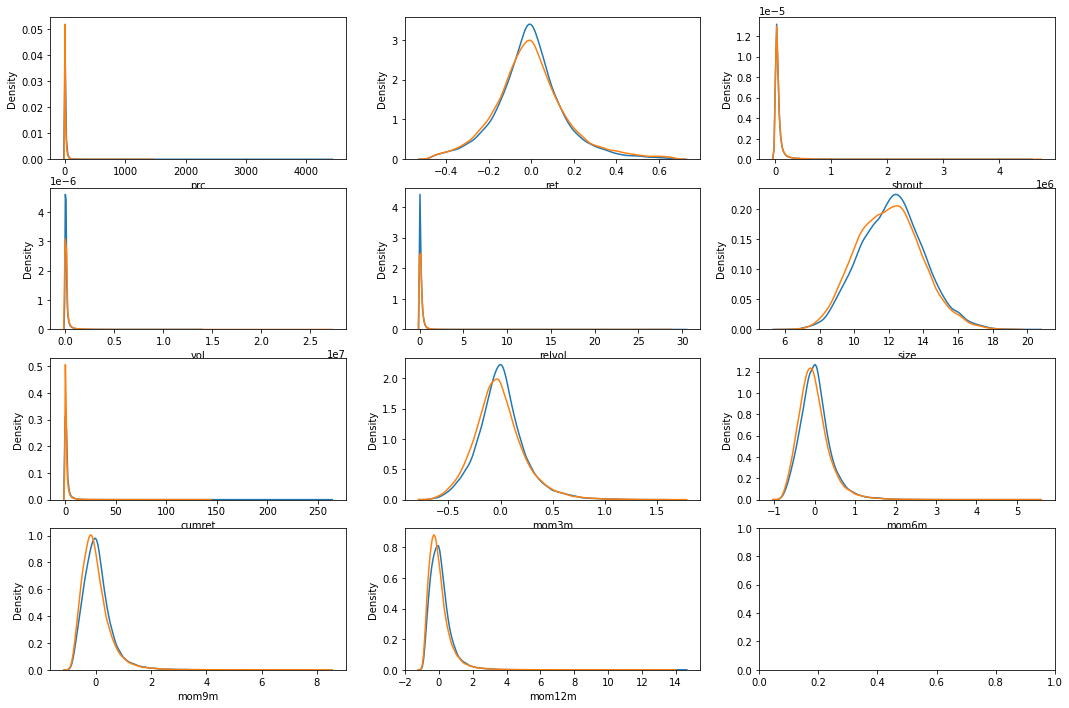

In [212]:
x_cols = ['prc', 'ret', 'shrout', 'vol', 'relvol', 'size', 'cumret', 'mom3m', 'mom6m', 'mom9m', 'mom12m']

fig, ax = plt.subplots(4, 3, figsize=(18, 12))
ax = ax.flatten()
for idx, col in enumerate(x_cols):
    sns.kdeplot(crsp[crsp['tgt_label'] == 0][col], label='H', ax=ax[idx])
    sns.kdeplot(crsp[crsp['tgt_label'] == 9][col], label='L', ax=ax[idx])
plt.show()

# Feature selection

- columns 중에서 H distribution이 오른쪽으로 더 skew 되어 있는 feature만 input으로 선택

In [213]:
features = ['size', 'ret', 'mom3m', 'mom6m', 'mom9m', 'mom12m']

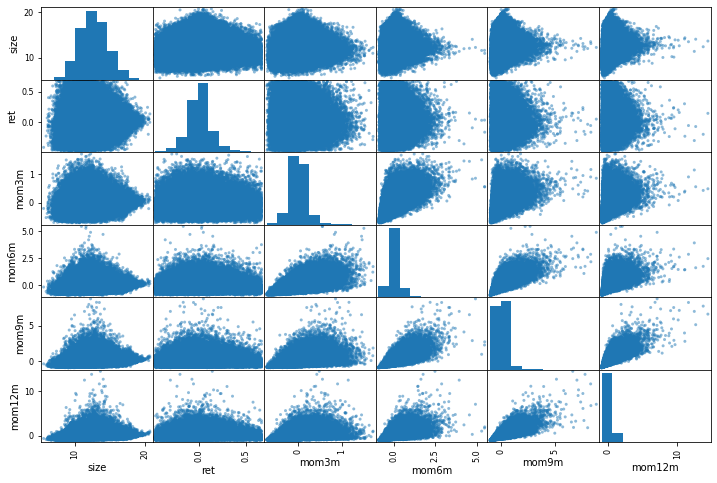

In [252]:
scatter_matrix(crsp[features], figsize=(12, 8))
plt.show()

In [215]:
train = crsp[crsp.date.dt.year <= 2009]
test = crsp[crsp.date.dt.year == 2010]

x_train = train[features].values
y_train = train['tgt_label'].values
x_test = test[features].values
y_test = test['tgt_label'].values

# XGBoost model

- tree ensemble 모형
- Error에 대한 decision tree를 생성해서 error를 줄이는 과정을 반복(Boosting)
- 간단하고 예측 성능이 뛰어남

$
y(x) = w_1m_1(x) + error_1(x) \\
error_1(x) = w_2m_2(x) + error_2(x) \\
error_2(x) = w_3m_3(x) + error_3(x) \\
...\\
y(x) = w_1m_1(x) + w_2m_2(x) + w_3m_3(x) + ... + error_n(x)
$


In [216]:
xgbc = xgboost.XGBClassifier(n_estimators=125, max_depth=5, learning_rate=0.03, verbosity=0)
xgbc.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=125,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [217]:
xgbc.score(x_test, y_test)

0.1259309666931307

# XGB Hyperparameter tuning

- Gridsearch를 통해서 후보군 중에 최적값 탐색
- Gridsearch를 통해 찾아낸 하이퍼파라미터 근처 범위로 BayesianOptimization 탐색을 해서 최종 파라미터 결정

In [218]:
params = {'max_depth': [4, 5],
         'n_estimators': [125, 150, 175],
         'learning_rate': [0.01, 0.03, 0.06]}

grid = GridSearchCV(xgbc, params, cv=3)

In [219]:
grid.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.03, max_bin=256,
                                     max_cat_to_onehot=4, max_delta_step=0,
                                     max_depth=5, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                          

In [220]:
grid_xgbc = grid.best_estimator_
grid_xgbc

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.06, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=125,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [221]:
grid_xgbc.fit(x_train, y_train)
grid_xgbc.score(x_test, y_test)

0.12479679407205777

In [222]:
grid_xgbc.feature_importances_

array([0.1472068 , 0.15088087, 0.14436166, 0.14004101, 0.14754823,
       0.26996148], dtype=float32)

In [223]:
def SCORE(alg, x, y):
    pred = alg.predict(x)
    return metrics.accuracy_score(pred, y)

In [224]:
def XGB_cv(max_depth, learning_rate, n_estimators, gamma, min_child_weight, max_delta_step,
          subsample, colsample_bytree, verbosity=0):
    
    model = xgboost.XGBClassifier(max_depth=int(max_depth),
                                learning_rate=learning_rate,
                                n_estimators=int(n_estimators),
                                verbosity=verbosity,
                                gamma=gamma,
                                min_child_weight=min_child_weight,
                                max_delta_step=max_delta_step,
                                subsample=subsample,
                                colsample_bytree=colsample_bytree)
    
    score = cross_val_score(model, x_train, y_train, scoring=SCORE, cv=3).mean()
    return score

pbounds = {'max_depth': (4, 6),
          'learning_rate': (0.02, 0.08),
          'n_estimators': (110, 140),
          'gamma': (0.0, 0.3),
          'min_child_weight': (1, 5),
          'max_delta_step': (0, 0.1),
          'subsample': (0.3, 0.9),
          'colsample_bytree': (0.3, 1.0)}

xgboostC = BayesianOptimization(f=XGB_cv, pbounds=pbounds, verbose=2)

xgboostC.maximize(init_points=1, n_iter=10)

xgboostC.max

|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.1246   |  0.3054   |  0.204    |  0.06013  |  0.01208  |  5.647    |  2.693    |  110.2    |  0.8553   |
|  2        |  0.1342   |  0.3674   |  0.2536   |  0.06498  |  0.04768  |  4.723    |  3.481    |  122.2    |  0.6813   |
|  3        |  0.1332   |  0.4981   |  0.1616   |  0.0476   |  0.0564   |  4.864    |  3.339    |  122.3    |  0.8252   |
|  4        |  0.1318   |  0.3      |  0.3      |  0.08     |  0.0      |  4.0      |  5.0      |  120.6    |  0.3      |
|  5        |  0.132    |  0.3      |  0.3      |  0.08     |  0.0      |  4.0      |  2.384    |  120.7    |  0.3      |
|  6        |  0.1204   |  0.3      |  0.3      |  0.08     |  0.000939 |  4.0      |  4.741    |  123.2    |  0.3      |
|  7        |  0.1307   

{'target': 0.1376385214526191,
 'params': {'colsample_bytree': 1.0,
  'gamma': 0.0,
  'learning_rate': 0.02,
  'max_delta_step': 0.1,
  'max_depth': 5.16505202208712,
  'min_child_weight': 4.165122578185092,
  'n_estimators': 121.7345761217804,
  'subsample': 0.3}}

In [225]:
best_xgbc = xgboost.XGBClassifier(max_depth=int(xgboostC.max['params']['max_depth']),
                                 learning_rate=xgboostC.max['params']['learning_rate'],
                                 n_estimators=int(xgboostC.max['params']['n_estimators']),
                                 gamma=xgboostC.max['params']['gamma'],
                                 min_child_weight=xgboostC.max['params']['min_child_weight'],
                                 max_delta_step=xgboostC.max['params']['max_delta_step'],
                                 subsample=xgboostC.max['params']['subsample'],
                                 colsample_bytree=xgboostC.max['params']['colsample_bytree'],
                                 num_class=10,
                                 objective='multi: softprob',
                                 verbosity=0)

In [226]:
best_xgbc.fit(x_train, y_train)
best_xgbc.score(x_test, y_test)

0.12732977959245398

In [227]:
best_xgbc.score(x_test, y_test) / grid_xgbc.score(x_test, y_test)

1.0202968797334142

- Gridsearch를 통해 찾아낸 파라미터보다 accuracy 2%가량 향상

# XGB Feature importances

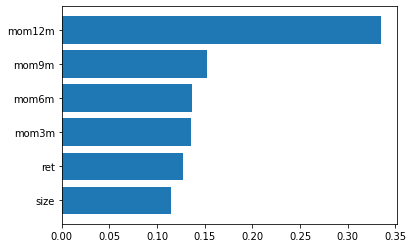

In [228]:
plt.barh(features, sorted(best_xgbc.feature_importances_, reverse=False))
plt.show()

# MLP Model

- Dense layer 사이 Dropout layer를 추가해서 오버피팅을 줄임
- Adam optimizer는 디폴트값이 제일 점수가 잘나와서 그대로 사용

In [229]:
model = Sequential()
model.add(Dense(32, input_dim=len(features), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

In [230]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                224       
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 10)                330       
                                                                 
Total params: 1,610
Trainable params: 1,610
Non-trainable params: 0
_________________________________________________________________


In [231]:
# optimizer = Adam(learning_rate=0.01, decay=1e-4)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [232]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [233]:
history = model.fit(x_train, y_train, epochs=200, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/200
6817/6817 [==============================] - 6s 879us/step - loss: 2.3105 - accuracy: 0.1078 - val_loss: 2.3034 - val_accuracy: 0.1031
Epoch 2/200
6817/6817 [==============================] - 7s 996us/step - loss: 2.2849 - accuracy: 0.1217 - val_loss: 2.2819 - val_accuracy: 0.1237
Epoch 3/200
6817/6817 [==============================] - 7s 960us/step - loss: 2.2770 - accuracy: 0.1242 - val_loss: 2.2778 - val_accuracy: 0.1261
Epoch 4/200
6817/6817 [==============================] - 8s 1ms/step - loss: 2.2740 - accuracy: 0.1265 - val_loss: 2.2764 - val_accuracy: 0.1277
Epoch 5/200
6817/6817 [==============================] - 6s 910us/step - loss: 2.2726 - accuracy: 0.1280 - val_loss: 2.2729 - val_accuracy: 0.1294
Epoch 6/200
6817/6817 [==============================] - 6s 928us/step - loss: 2.2710 - accuracy: 0.1284 - val_loss: 2.2724 - val_accuracy: 0.1304
Epoch 7/200
6817/6817 [==============================] - 6s 942us/step - loss: 2.2699 - accuracy: 0.1287 - val_loss: 2.2

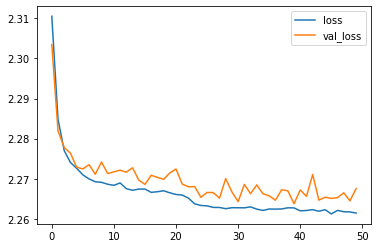

In [234]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [235]:
model.evaluate(x_test, y_test)

827/827 [==============================] - 1s 628us/step - loss: 2.2727 - accuracy: 0.1249


[2.2726800441741943, 0.12491021305322647]

In [236]:
metrics.accuracy_score(np.argmax(best_xgbc.predict_proba(x_test) + model.predict(x_test), axis=1), y_test)

0.1282371176893123

- XGB와 MLP의 probability를 합해서 가장 높은 label 값을 output으로 사용함
- XGB 0.127329 / MLP 0.124910 보다 약간 향상된 정확도

# Trainning data setup

- 2000 ~ 2009년 데이터는 model setup에서 trainning data로 사용
- 나머지 2010 ~ 2018년 데이터는 1년 단위로 추가 학습

In [237]:
year_data = []

for i in range(9):
    new_data = crsp[crsp.date.dt.year == 2010+i]
    year_data.append(new_data)

In [238]:
# nn_path = 'nn.pickle'
# xgbc_path = 'xgbc.pickle'

# with open(xgbc_path, 'wb') as f:
#     pickle.dump(xgbc, f)
# with open(nn_path, 'wb') as f:
#     pickle.dump(model, f)

In [239]:
xgbc = best_xgbc
nn = model

# Ensemble & Rolling train

- XGBC를 통해 예측한 probability와 MLP에서 예측한 Probability를 합쳐서 가장 높은 확률의 라벨을 output으로 사용
- 1년 단위로 추가적인 데이터만 학습해서 기존 모델을 재사용함

In [240]:
r_h_ew = []; r_l_ew = []  # equal-weight 
r_h_vw = []; r_l_vw = []  # value-weight

for i, add in enumerate(year_data):
    # with open(xgbc_path, 'rb') as f:
    #     xgbc = pickle.load(f)
    # with open(nn_path, 'rb') as f:
    #     nn = pickle.load(f)
    print('{}'.format(2010+i))
    for m, g_m in add.groupby('date'):
        train = g_m[features].values
        
        y_pred_xgbc = xgbc.predict_proba(train)
        y_pred_nn = nn.predict(train)
        y_pred = np.argmax((y_pred_xgbc + y_pred_nn), axis=1)
        
        hidx = y_pred==0
        lidx = y_pred==9
        
        rh = g_m.loc[hidx, 'tgt_ret']
        rl = g_m.loc[lidx, 'tgt_ret']
        print(f'{m} Number of stocks in H and L: {len(rh)}, {len(rl)}')
        
        wh_ew = (1/len(rh) if len(rh) else 0) * np.ones_like(rh)
        wl_ew = (1/len(rl) if len(rl) else 0) * np.ones_like(rl)

        # portfolio return
        r_h_ew.append(np.matmul(wh_ew, rh))
        r_l_ew.append(np.matmul(wl_ew, rl))

        # value-weight
        # portfolio weights
        # size factor는 log 취했던 값이기 때문에 exp로 다시 계산
        sizeh = np.exp(g_m.loc[hidx, 'size'])
        sizel = np.exp(g_m.loc[lidx, 'size'])
        wh_vw = sizeh/np.sum(sizeh)
        wl_vw = sizel/np.sum(sizel)

        # portfolio return
        r_h_vw.append(np.matmul(wh_vw, rh))
        r_l_vw.append(np.matmul(wl_vw, rl))
    
    # update: continue train
    xgbc.fit(add[features].values, add['tgt_label'].values)
    nn.fit(add[features].values, add['tgt_label'].values)
    # with open(xgbc_path, 'wb') as f:
    #     pickle.dump(xgbc, f)
    # with open(nn_path, 'wb') as f:
    #     pickle.dump(nn, f)
    
r_h_ew = np.array(r_h_ew)
r_l_ew = np.array(r_l_ew)
# long-short portfolio return
r_hl_ew = r_h_ew - r_l_ew 

r_h_vw = np.array(r_h_vw)
r_l_vw = np.array(r_l_vw)
# long-short portfolio return
r_hl_vw = r_h_vw - r_l_vw

2010
2010-01-29 00:00:00 Number of stocks in H and L: 234, 78
2010-02-26 00:00:00 Number of stocks in H and L: 241, 62
2010-03-31 00:00:00 Number of stocks in H and L: 233, 53
2010-04-30 00:00:00 Number of stocks in H and L: 177, 91
2010-05-28 00:00:00 Number of stocks in H and L: 284, 62
2010-06-30 00:00:00 Number of stocks in H and L: 288, 80
2010-07-30 00:00:00 Number of stocks in H and L: 162, 183
2010-08-31 00:00:00 Number of stocks in H and L: 238, 118
2010-09-30 00:00:00 Number of stocks in H and L: 107, 197
2010-10-29 00:00:00 Number of stocks in H and L: 158, 119
2010-11-30 00:00:00 Number of stocks in H and L: 212, 72
2010-12-31 00:00:00 Number of stocks in H and L: 183, 111
827/827 [==============================] - 1s 784us/step - loss: 2.2685 - accuracy: 0.1322
2011
2011-01-31 00:00:00 Number of stocks in H and L: 251, 258
2011-02-28 00:00:00 Number of stocks in H and L: 231, 208
2011-03-31 00:00:00 Number of stocks in H and L: 188, 224
2011-04-29 00:00:00 Number of stocks

In [241]:
data_index = crsp.sort_values('date')
data_index = data_index[data_index.date.dt.year >= 2010].date.unique()

In [242]:
sp500 = sp500[sp500.caldt.dt.year >= 2010][:107] # Benchmark

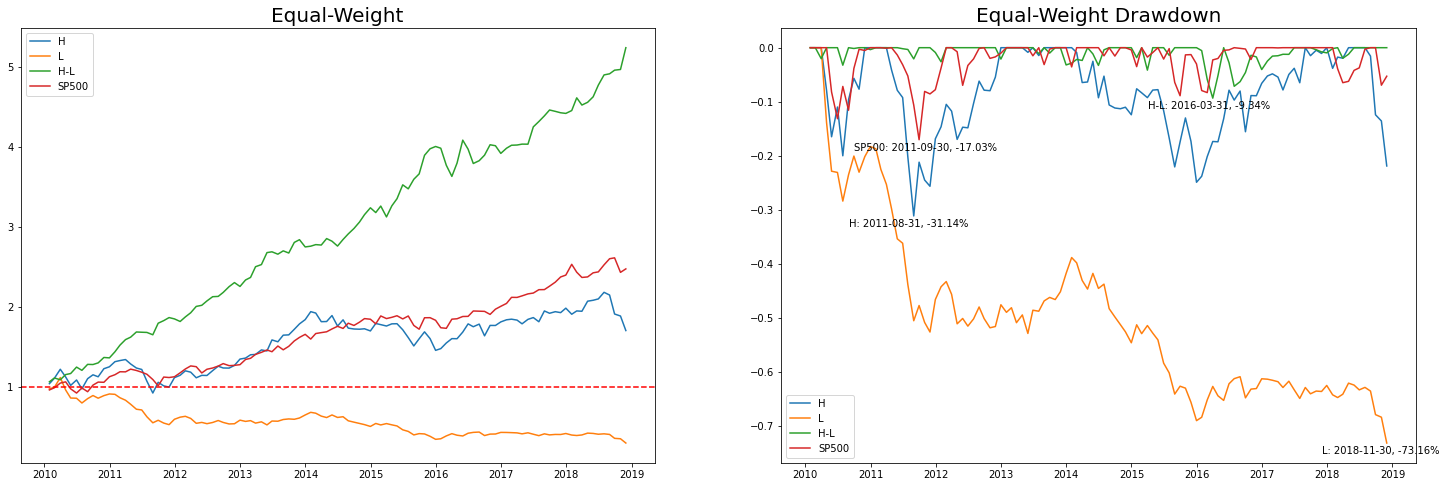

In [243]:
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

cumret = pd.DataFrame(0, index=data_index, columns=[])
cumret['H'] = (1 + r_h_ew).cumprod()
cumret['L'] = (1 + r_l_ew).cumprod()
cumret['H-L'] = (1 + r_hl_ew).cumprod()
cumret['SP500'] = np.array((1 + sp500.sprtrn).cumprod())

ax[0].plot(cumret, label=['H', 'L', 'H-L', 'SP500'])
ax[0].set_title('Equal-Weight', fontsize=20)
ax[0].axhline(color='r', y=1, linestyle='--')
ax[0].legend()

wealth_h_ew = cumret['H']
wealth_l_ew = cumret['L']
wealth_hl_ew = cumret['H-L']
wealth_sp500 = cumret['SP500']

previous_peak_h_ew = pd.Series(wealth_h_ew, index=data_index).cummax()
previous_peak_l_ew = pd.Series(wealth_l_ew, index=data_index).cummax()
previous_peak_hl_ew = pd.Series(wealth_hl_ew, index=data_index).cummax()
previous_peak_sp500 = pd.Series(wealth_sp500, index=data_index).cummax()

drawdown = pd.DataFrame(0, index=data_index, columns=[])
drawdown['H'] = (wealth_h_ew - previous_peak_h_ew) / previous_peak_h_ew
drawdown['L'] = (wealth_l_ew - previous_peak_l_ew) / previous_peak_l_ew
drawdown['H-L'] = (wealth_hl_ew - previous_peak_hl_ew) / previous_peak_hl_ew
drawdown['SP500'] = (wealth_sp500 - previous_peak_sp500) / previous_peak_sp500

for col in ['H', 'L', 'H-L', 'SP500']:
    min_day = drawdown[col][drawdown[col] == drawdown[col].min()]
    min_str = str(min_day.index[0]).split(' ')[0]
    ax[1].text(min_day.index[-1]-timedelta(weeks=52), drawdown[col].min()-0.02, '{}: {}, {:.2f}%'.format(col, min_str, drawdown[col].min()*100), fontsize=10)
mdd_ew = drawdown.min()

ax[1].set_title('Equal-Weight Drawdown', fontsize=20)
ax[1].plot(drawdown, label=['H', 'L', 'H-L', 'SP500'])
ax[1].legend()

plt.show()

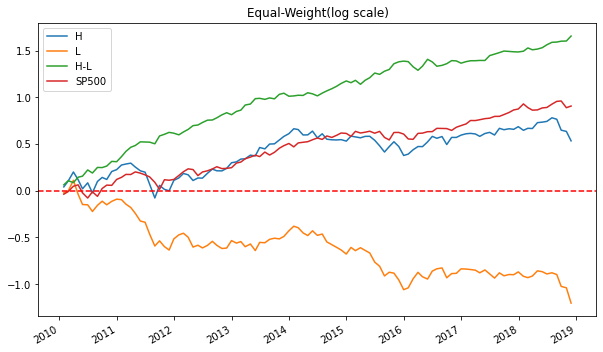

In [244]:
cumret_log = pd.DataFrame(0, index=data_index, columns=[])
cumret_log['H'] = np.log(cumret['H'])
cumret_log['L'] = np.log(cumret['L'])
cumret_log['H-L'] = np.log(cumret['H-L'])
cumret_log['SP500'] = np.log(cumret['SP500'])

cumret_log.plot(title='Equal-Weight(log scale)', figsize=(10, 6))
plt.axhline(color='r', y=0, linestyle='--')

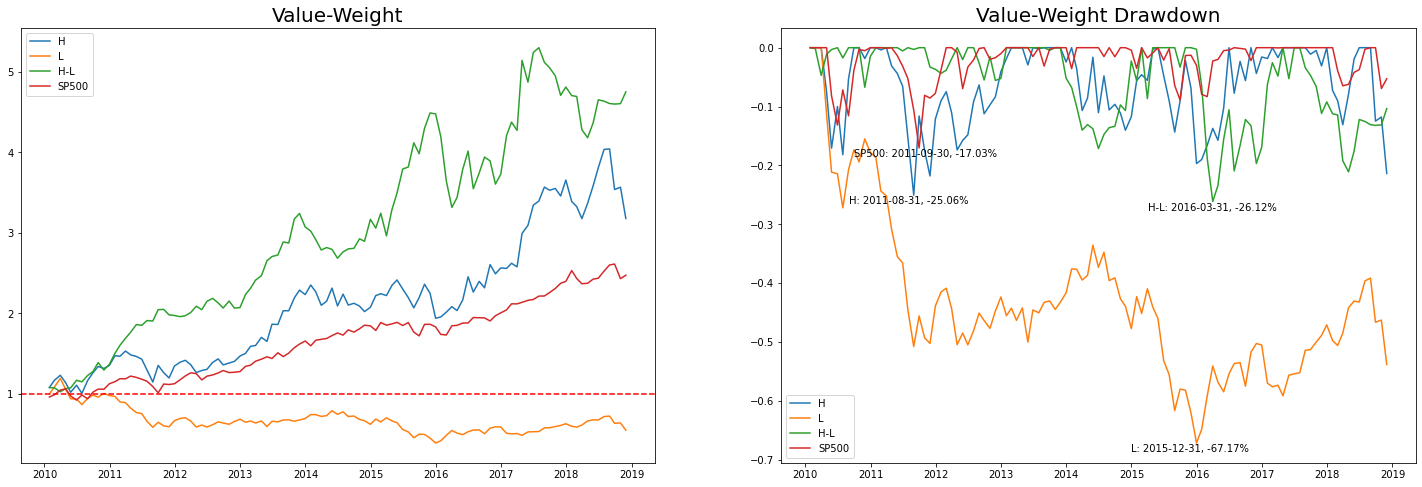

In [245]:
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

cumret = pd.DataFrame(0, index=data_index, columns=[])
cumret['H'] = (1 + r_h_vw).cumprod()
cumret['L'] = (1 + r_l_vw).cumprod()
cumret['H-L'] = (1 + r_hl_vw).cumprod()
cumret['SP500'] = np.array((1 + sp500.sprtrn).cumprod())

ax[0].plot(cumret, label=['H', 'L', 'H-L', 'SP500'])
ax[0].set_title('Value-Weight', fontsize=20)
ax[0].axhline(color='r', y=1, linestyle='--')
ax[0].legend()

wealth_h_vw = cumret['H']
wealth_l_vw = cumret['L']
wealth_hl_vw = cumret['H-L']
wealth_sp500 = cumret['SP500']

previous_peak_h_vw = pd.Series(wealth_h_vw, index=data_index).cummax()
previous_peak_l_vw = pd.Series(wealth_l_vw, index=data_index).cummax()
previous_peak_hl_vw = pd.Series(wealth_hl_vw, index=data_index).cummax()
previous_peak_sp500 = pd.Series(wealth_sp500, index=data_index).cummax()

drawdown = pd.DataFrame(0, index=data_index, columns=[])
drawdown['H'] = (wealth_h_vw - previous_peak_h_vw) / previous_peak_h_vw
drawdown['L'] = (wealth_l_vw - previous_peak_l_vw) / previous_peak_l_vw
drawdown['H-L'] = (wealth_hl_vw - previous_peak_hl_vw) / previous_peak_hl_vw
drawdown['SP500'] = (wealth_sp500 - previous_peak_sp500) / previous_peak_sp500

for col in ['H', 'L', 'H-L', 'SP500']:
    min_day = drawdown[col][drawdown[col] == drawdown[col].min()]
    min_str = str(min_day.index[0]).split(' ')[0]
    ax[1].text(min_day.index[-1]-timedelta(weeks=52), drawdown[col].min()-0.015, '{}: {}, {:.2f}%'.format(col, min_str, drawdown[col].min()*100), fontsize=10)
mdd_vw = drawdown.min()

ax[1].set_title('Value-Weight Drawdown', fontsize=20)
ax[1].plot(drawdown, label=['H', 'L', 'H-L', 'SP500'])
ax[1].legend()

plt.show()

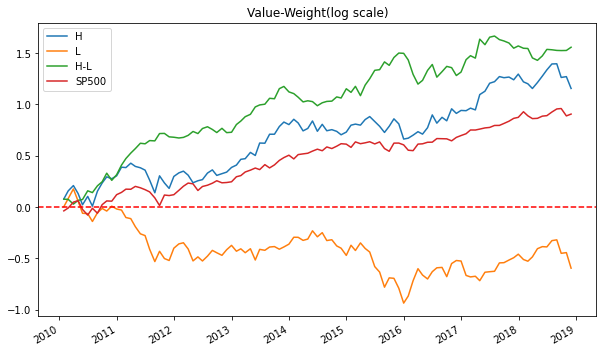

In [246]:
cumret_log = pd.DataFrame(0, index=data_index, columns=[])
cumret_log['H'] = np.log(cumret['H'])
cumret_log['L'] = np.log(cumret['L'])
cumret_log['H-L'] = np.log(cumret['H-L'])
cumret_log['SP500'] = np.log(cumret['SP500'])

cumret_log.plot(title='Value-Weight(log scale)', figsize=(10, 6))
plt.axhline(color='r', y=0, linestyle='--')

In [247]:
def evaluate(r_p):
    cum_r = (1 + r_p).prod() - 1 # 복리
    mean_r = 12 * np.mean(r_p) # 이건 걍 산술평균이라 복리 수익률은 아님
    std_r = np.sqrt(12) * np.std(r_p)
    sharpe = mean_r / std_r
    
    return [cum_r, mean_r, std_r, sharpe]

In [248]:
pftab = pd.DataFrame(0, index=['cum', 'mean', 'std', 'sharpe'], columns=[])

pftab['EW_H'] = evaluate(r_h_ew)
pftab['EW_L'] = evaluate(r_l_ew)
pftab['EW_HL'] = evaluate(r_hl_ew)

pftab['VW_H'] = evaluate(r_h_vw)
pftab['VW_L'] = evaluate(r_l_vw)
pftab['VW_HL'] = evaluate(r_hl_vw)

pftab['SP500'] = evaluate(sp500.sprtrn)
pftab

,EW_H,EW_L,EW_HL,VW_H,VW_L,VW_HL,SP500
cum,0.704759,-0.700062,4.238134,2.178206,-0.449212,3.750532,1.475264
mean,0.076500,-0.115243,0.191743,0.155131,-0.038208,0.193339,0.109146
std,0.181275,0.193558,0.096478,0.223428,0.237625,0.187357,0.119052
sharpe,0.422013,-0.595391,1.987417,0.694324,-0.160791,1.031930,0.916791


In [249]:
mdd = pd.concat([mdd_ew[:3], mdd_vw])
mdd.index = pftab.columns
mdd.name = 'mdd'
mdd = pd.DataFrame(mdd).T
mdd

,EW_H,EW_L,EW_HL,VW_H,VW_L,VW_HL,SP500
mdd,-0.311357,-0.731558,-0.093355,-0.250629,-0.671661,-0.261201,-0.170276


In [250]:
summary = pd.concat([pftab, mdd], axis=0)
summary.T

,cum,mean,std,sharpe,mdd
EW_H,0.704759,0.076500,0.181275,0.422013,-0.311357
EW_L,-0.700062,-0.115243,0.193558,-0.595391,-0.731558
EW_HL,4.238134,0.191743,0.096478,1.987417,-0.093355
VW_H,2.178206,0.155131,0.223428,0.694324,-0.250629
VW_L,-0.449212,-0.038208,0.237625,-0.160791,-0.671661
VW_HL,3.750532,0.193339,0.187357,1.031930,-0.261201
SP500,1.475264,0.109146,0.119052,0.916791,-0.170276


# Result

- 최적의 전략은 EW_HL
- HL 전략은 EW, VW 모두 SP500보다 샤프지수가 높게 나옴
- EW_HL은 가장 높은 수익률, 가장 높은 샤프지수, 가장 낮은 변동성, 가장 낮은 MDD. 모든 면에서 가장 좋은 성과를 나타냄

- XGBC와 MLP을 함께 사용해서 acc가 약간 향상됨
- 예측한 라벨 중에서 예측 확률이 70 ~ 80% 이상인 결과값만 활용해서 H/L 전략을 사용해도 좋을 것으로 예상됨
